In [1]:
# imports
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import utils
import SIREN_utils
import json
from torch.utils.data import DataLoader
import os
import h5py
import math
import random
import scienceplots

from SIREN_utils import (
    extract_diagonals,
    fold_OP_mat,
    matrix_processing,
    plot_complex_matrix,
    get_interpolated_matrix,
    Siren,
    check_D4_symmetries,
    apply_periodic_boundary_conditions,
    enforce_D4_symmetries_pytorch,
    get_normalized_coords,
    run_model_inference,
    print_comparison,
    reformat_matrix_from_diagonals,
    unfold_OP_mat
)

In [2]:
plt.style.use(["science", "notebook", "grid"])

### Technical Stuff (Engineering)

In [3]:
import sys

# Set the cache size limit to the largest possible integer
torch._dynamo.config.cache_size_limit = sys.maxsize

print(f"torch._dynamo.config.cache_size_limit is now set to: {torch._dynamo.config.cache_size_limit}")

torch._dynamo.config.cache_size_limit is now set to: 9223372036854775807


In [4]:
torch.set_float32_matmul_precision('highest')

In [5]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

Using device: cuda



### Running training script

In [ ]:
# state variables
U = 3
error_c='2e-5'
label = f"U_{U}_ground_state"

In [ ]:
# for lr scheduler
MAX_LR = 1e-3
MAX_NUM_EPOCHS = 5_00   # 500 initially, then 5000
NUM_WARMUP_EPOCHS = 20


def training_script(num_freqs: int, index: int = 0, device = device):
    # Set random seed for reproducibility
    torch.manual_seed(index)
    np.random.seed(index)
    random.seed(index)

    # number of frequencies
    NUM_FREQS = num_freqs

    # make a new folder for this test
    folder_name = f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_{U}_ground_state/{NUM_FREQS}_test_index_{index}"

    # dataset files
    TRAIN_DATASET1 = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/U_{U}_ground_state/{error_c}/hubbard_model_lowest_energy_8x8_U_{U}_ground_state.h5"
    TRAIN_DATASET2 = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/U_{U}_ground_state/{error_c}/hubbard_model_lowest_energy_10x10_U_{U}_ground_state.h5"
    VAL_DATASET = f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/U_{U}_ground_state/{error_c}/hubbard_model_lowest_energy_18x18_U_{U}_ground_state.h5"

    filenames_dict = {
        TRAIN_DATASET1: 1000,
        TRAIN_DATASET2: 1000,
    }
    chunks_8 = 50
    chunks_10 = 50

    # get normalization constants
    stats = utils.get_normalization_constants_3x3(filenames_dict, write_to=f"normalization_constants.json")

    print("Normalization Constants:")
    print(stats)

    # Check if CUDA is available, otherwise use CPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    dims = [8, 10, 18]    # could go (for example) from 8 to 18 in increments of 2
    filenames = [f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/diagonal_coords_{d}x{d}.pt" for d in dims]

    with h5py.File(TRAIN_DATASET1, 'r') as f:
        io_dim = f['dataset'].shape[-1]

    model = utils.HF_SimpleModel(
        filenames,
        num_layers = 3,
        input_dim = io_dim,
        embed_dim = 64,
        output_dim = io_dim,
        num_heads = 4,
        num_freqs = NUM_FREQS,
        dim_feedforward = 128,
        input_dropout = 0.1,
        output_dropout = 0.0,
        dropout = 0.1,
        device = device
    )

    try:
        os.mkdir(folder_name)
        print(f"Folder '{folder_name}' created successfully.\n")
    except FileExistsError:
        print(f"Folder '{folder_name}' already exists.\n")

        # Load the saved state_dict
        print(f"Loading model from {folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth")
        state_dict = torch.load(f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth")

        # Create a new state_dict without the prefix
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('_orig_mod.'):
                name = k[10:] # remove `_orig_mod.`
                new_state_dict[name] = v
            else:
                new_state_dict[k] = v

        # Load the corrected state_dict
        model.load_state_dict(new_state_dict)
        
    except OSError as e:
        print(f"Error creating folder: {e}\n")
    
    # compile the model
    model = torch.compile(model, mode="max-autotune", fullgraph=True)

    # make training and validation datasets
    training_data1 = utils.HF_3x3_Dataset(TRAIN_DATASET1, stats)
    print(f"Training dataset length: {training_data1.__len__()}\n")

    training_data2 = utils.HF_3x3_Dataset(TRAIN_DATASET2, stats)
    print(f"Training dataset length: {training_data2.__len__()}\n")

    validation_data = utils.HF_3x3_Dataset(VAL_DATASET, stats)
    print(f"Test dataset length: {validation_data.__len__()}\n")

    # training and test dataloaders
    train_dataloader1 = DataLoader(training_data1, chunks_8, shuffle=True, pin_memory=True, num_workers=1)
    train_dataloader2 = DataLoader(training_data2, chunks_10, shuffle=True, pin_memory=True, num_workers=1)
    val_dataloader = DataLoader(validation_data, 4, shuffle=True, pin_memory=True, num_workers=1)

    # Loss function and optimizer
    loss_fn = torch.nn.MSELoss(reduction = "sum")
    optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR)

    # Define schedulers
    min_lr = 1e-7
    k = min_lr / MAX_LR
    linear_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=k, end_factor=1.0, total_iters=NUM_WARMUP_EPOCHS)

    cosine_annealing = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = (MAX_NUM_EPOCHS - NUM_WARMUP_EPOCHS))

    # Combine them
    scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[linear_warmup, cosine_annealing],
        milestones=[NUM_WARMUP_EPOCHS]
    )


    train_losses = []
    val_losses = []

    # train the model and record the loss for the training and validation datasets
    for t in range(MAX_NUM_EPOCHS):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_losses.append(
            utils.train_loop([train_dataloader1, train_dataloader2], model, loss_fn, optimizer, scheduler, device)
        )
        val_losses.append(utils.test_loop([val_dataloader], model, loss_fn, device))
        # save the model occasionally
        if (t % 100 == 0):
            print("Saving model...")
            torch.save(
                model.state_dict(),
                f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_epoch_{t + 1}.pth",
            )
            print("Model saved!\n")
    print("Done!\n")

    print(f"Training Losses (1-{MAX_NUM_EPOCHS}): {train_losses}")
    print(f"Test Losses (1-{MAX_NUM_EPOCHS}): {val_losses}\n")

    utils.plot_losses(train_losses, val_losses, img_filename=f"{folder_name}/train_test_losses.png")

    # saving model
    torch.save(
        model.state_dict(),
        f"{folder_name}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth",
    )

    return min(val_losses)

In [ ]:
for num_freqs in [32, 64, 96, 128, 256, 512, 1024]:
    training_script(num_freqs)

In [ ]:
for num_freqs in [16, 48]:
    training_script(num_freqs)

In [ ]:
# to run many trials with a single frequency
for i in range(1, 100):
    training_script(32, index=i)

In [ ]:
# e.g. if you want to retrain from a checkpoint
training_script(32, index=14)

### Inference / Evaluation

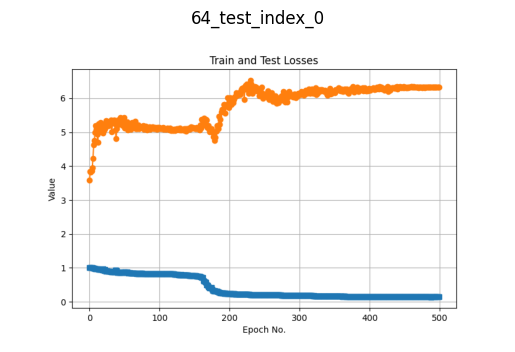

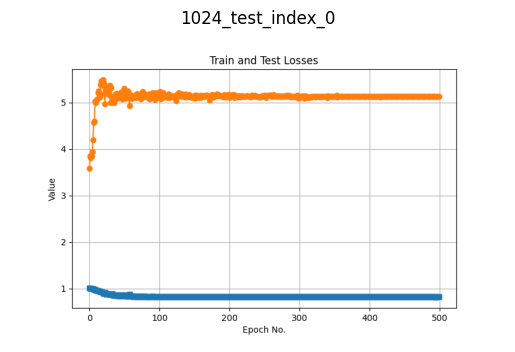

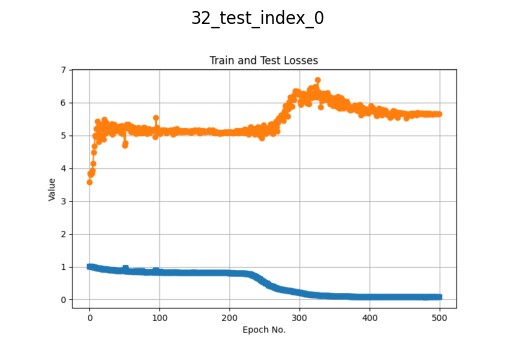

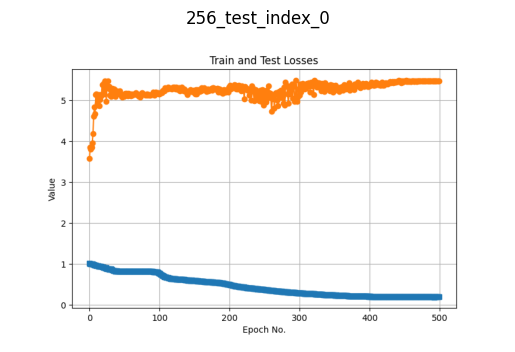

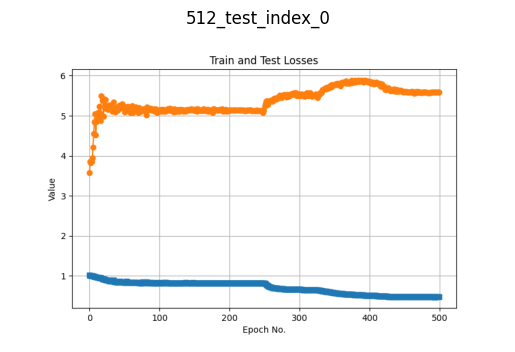

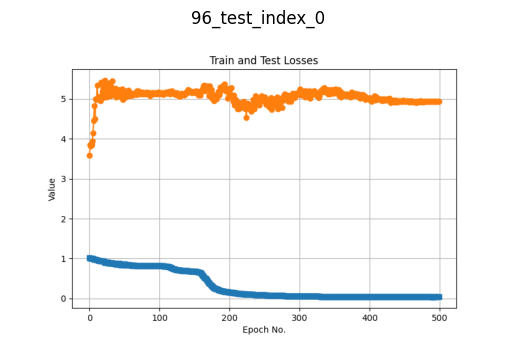

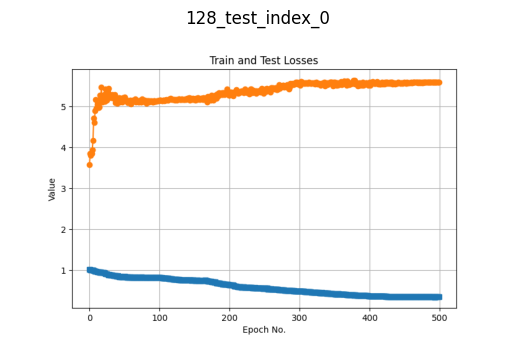

In [3]:
import re
import matplotlib.image as mpimg

# Root directory to start search (edit this if needed)
root_dir = "/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_3_ground_state"

# Regex to match folder names like "48_test_index_123"
pattern = re.compile(r"\d+_test_index_0")

for dirpath, dirnames, filenames in os.walk(root_dir):
    folder_name = os.path.basename(dirpath)
    if pattern.fullmatch(folder_name):
        img_path = os.path.join(dirpath, "train_test_losses.png")
        if os.path.isfile(img_path):
            img = mpimg.imread(img_path)
            plt.figure()
            plt.imshow(img)
            plt.axis("off")
            plt.title(folder_name)
plt.show()

In [8]:
def denormalize_channels(tensor, stats):
    num_indices = tensor.shape[-1]
    new_tensor = torch.zeros_like(tensor)
    for i in range(num_indices):
        new_tensor[..., i] = utils.denormalize(tensor[..., i], stats[f"elt_{i}"]["results"]["mean"], stats[f"elt_{i}"]["results"]["std_dev"])
    return new_tensor

In [9]:
def get_model_output(output_matrix, diag_idx, alpha):

    with h5py.File(
        "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/U_1_excited_state/U_1_excited_state.h5",
        "r",
    ) as f:
        OP_8x8 = f["OP_8x8"][()]
        print(OP_8x8.shape)
        OP_18x18 = f["OP_18x18"][()]
        print(OP_18x18.shape)
    
    # first make sure they have the same pattern
    assert np.max(np.abs(get_interpolated_matrix(OP_8x8, 18) - OP_18x18)) < 0.4, (
        "Sorry, patterns do not match"
    )

    diagonal_matrix_8x8 = extract_diagonals(fold_OP_mat(OP_8x8))[diag_idx][:, :, alpha, alpha]
    diagonal_matrix_18x18 = extract_diagonals(fold_OP_mat(OP_18x18))[diag_idx][:, :, alpha, alpha]

    # determine which type of B.C.'s to apply
    clipped_OP_8x8 = diagonal_matrix_8x8[1:, 1:]
    if (check_D4_symmetries(clipped_OP_8x8)["reflection_anti_diag"] is True):
        mode = "adjacent"
    else:
        mode = "opposite"
    print(f"Selected mode: {mode}")

    # preprocess the diagonal matrices
    diag_matrix_8x8_np = apply_periodic_boundary_conditions(diagonal_matrix_8x8, mode=mode).numpy()
    diag_matrix_18x18_np = apply_periodic_boundary_conditions(diagonal_matrix_18x18, mode=mode).numpy()

    # get symmetries
    symmetries_8x8 = check_D4_symmetries(diag_matrix_8x8_np)

    # symmetrize the model output
    output_18x18_matrix = apply_periodic_boundary_conditions(output_matrix, mode=mode)
    output_18x18_np = enforce_D4_symmetries_pytorch(output_18x18_matrix, symmetries_8x8).numpy()
    print_comparison(diag_matrix_18x18_np, output_18x18_np)

    return output_18x18_np[:18, :18]

In [10]:
def main_function(num_freqs, dim, indices, test_index=0, epoch=None):
    NUM_FREQS = num_freqs

    # directory for model + normalization constants
    folder_name = "old_NN_U_1_excited_state"
    directory = f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/{folder_name}/"

    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    num_samples = indices[1] - indices[0]

    # get the filenames
    dims = list(range(8, 19, 2))    # should go from 8 to 18 in increments of 2
    filenames = [f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/diagonal_coords_{d}x{d}.pt" for d in dims]

    # load model (make sure matches what's in the folder)
    model = utils.HF_SimpleModel(
        filenames,
        num_layers = 3,
        input_dim = 4,
        embed_dim = 64,
        output_dim = 4,
        num_heads = 4,
        num_freqs = NUM_FREQS,
        dim_feedforward = 128,
        input_dropout = 0.1,
        output_dropout = 0.0,
        dropout = 0.1,
        device = device
    )

    # Load the saved state_dict
    if epoch is None:
        model_filename = f"{directory}{NUM_FREQS}_test_index_{test_index}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_final.pth"
    else:
        model_filename = f"{directory}{NUM_FREQS}_test_index_{test_index}/hubbard_model_2BPV_HF_model_num_freqs_{NUM_FREQS}_epoch_{epoch}.pth"

    print(f"Loading model from {model_filename}")
    state_dict = torch.load(model_filename)

    # Create a new state_dict without the prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            name = k[10:] # remove `_orig_mod.`
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v

    # Load the corrected state_dict
    model.load_state_dict(new_state_dict)


    # get number of trainable parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params}")

    # load normalization constants from file
    with open(directory + f"normalization_constants.json", "r") as f:
        stats = json.load(f)

    print("Normalization Constants:")
    print(stats)

    # load dataset
    eval_dataset = utils.HF_3x3_Dataset(f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/U_1_excited_state/hubbard_model_lowest_energy_{dim}x{dim}_U_1_excited_state.h5", stats, indices=indices)
    print(f"\nDataset size: {eval_dataset.__len__()}")

    # make a new DataLoader for testing purposes
    eval_dataloader = DataLoader(
        eval_dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=1
    )

    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    num_batches = len(eval_dataloader)
    test_loss = 0
    loss_fn = torch.nn.MSELoss()
    results_list = []


    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in eval_dataloader:
            # Move data to the appropriate device (CPU/GPU)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # convert to correct format
            pred = denormalize_channels(pred, stats)
            pred = pred.cpu().numpy()
            results_list.append(pred)
    
    results_list = np.concatenate(results_list, axis=0)
    # results_list should now be of shape (num_samples, L^2, 4)

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_excited_state/old_NN_18x18_U_1_excited_state_num_freqs_{NUM_FREQS}_test1.h5", "w") as f:
        for i in range(num_samples):
            OP_tensor = results_list[i]
            count = 0
            diag_list = []
            for diag_idx in (0, 1):
                diag_tensor = np.zeros((dim, dim, 2, 2))
                for alpha in (0, 1):
                    diag_tensor[:, :, alpha, alpha] = get_model_output(OP_tensor[:, count].reshape(dim, dim), diag_idx, alpha)
                    count += 1
                diag_list.append(diag_tensor)
            
            folded_OP_mat = reformat_matrix_from_diagonals(diag_list)

            OP_mat = unfold_OP_mat(folded_OP_mat)
            OP_mat = np.transpose(OP_mat)
            OP_mat = np.array([OP_mat.real, OP_mat.imag])
            f.create_dataset(f"ML_{i+1}", data=OP_mat)

    return results_list

In [11]:
# generate outputs
main_function(num_freqs=32, dim=18, indices=(0, 1), test_index=14, epoch=201)

Using device: cuda


Loading model from /blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_excited_state/32_test_index_14/hubbard_model_2BPV_HF_model_num_freqs_32_epoch_201.pth
Number of trainable parameters: 101596
Normalization Constants:
{'elt_0': {'initial': {'mean': 0.9986994862556458, 'std_dev': 0.5773247480392456}, 'results': {'mean': 0.511543333530426, 'std_dev': 0.43008190393447876}}, 'elt_1': {'initial': {'mean': 0.996049702167511, 'std_dev': 0.5768352746963501}, 'results': {'mean': 0.48845669627189636, 'std_dev': 0.43008193373680115}}, 'elt_2': {'initial': {'mean': 1.0425496101379395, 'std_dev': 0.4079671800136566}, 'results': {'mean': 0.18570081889629364, 'std_dev': 0.1448773443698883}}, 'elt_3': {'initial': {'mean': 0.9560105204582214, 'std_dev': 0.40651735663414}, 'results': {'mean': -0.18570081889629364, 'std_dev': 0.1448773443698883}}}

Dataset size: 1
Test loss: 0.149937 

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90          

array([[[-0.0255338 , -0.02273068,  0.04431114, -0.04432209],
        [-0.0233953 , -0.01957288,  0.04567814, -0.04568392],
        [-0.02023238, -0.02018413,  0.05794327, -0.05794264],
        ...,
        [-0.01494873, -0.00232929,  0.10054932, -0.10055227],
        [-0.01787442, -0.00359771,  0.09891215, -0.09891469],
        [-0.00486678,  0.0103676 ,  0.1102544 , -0.11026074]]],
      shape=(1, 324, 4), dtype=float32)

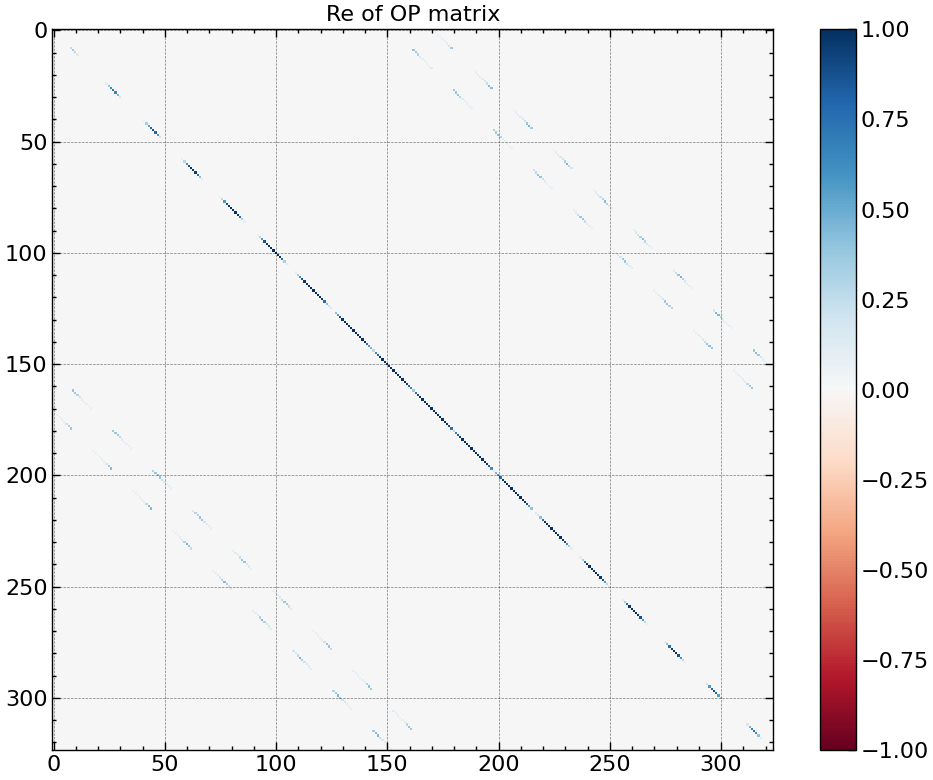

In [ ]:
# check outputs
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/old_NN_U_1_excited_state/old_NN_18x18_U_1_excited_state_num_freqs_32_test1.h5", 'r') as f:
    OP_mat = np.transpose(f['ML_1'][()])
    OP_mat = OP_mat[:, :, 0] + (1j * OP_mat[:, :, 1])
    plot_complex_matrix(fold_OP_mat(OP_mat)[:, :, 0, 0])

In [13]:
with h5py.File(
        "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/U_1_excited_state/U_1_excited_state.h5",
        "r",
    ) as f:
        OP_18x18 = f["OP_18x18"][()]
        print(OP_18x18.shape)

print_comparison(OP_mat, OP_18x18)

(648, 648)
Max diff: 0.3028670763965917
MSE: 1.992305568379723e-05


(np.float64(0.3028670763965917), np.float64(1.992305568379723e-05))